In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
from timeit import default_timer as timer

from neural_diff_eq.problem import Variable
from neural_diff_eq.setting import Setting
from neural_diff_eq.problem.domain import (Rectangle,
                                           Interval,
                                           Circle)
from neural_diff_eq.problem.condition import (DirichletCondition,
                                              DiffEqCondition,
                                              DataCondition)
from neural_diff_eq.models.fcn import SimpleFCN
from neural_diff_eq import PINNModule
from neural_diff_eq.utils import laplacian, jac
from neural_diff_eq.utils.fdm import FDM, create_validation_data
from neural_diff_eq.utils.plot import Plotter
from neural_diff_eq.utils.evaluation import (get_min_max_inside,
                                             get_min_max_boundary)
from neural_diff_eq.setting import Setting

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPUs to use

#pl.seed_everything(43) # set a global seed
torch.cuda.is_available()

/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


False

In [2]:
w, h = 1, 1
t0, tend = 0, 8
Re = 10

In [3]:
from neural_diff_eq.problem.domain.domain_operations import Cut
R = Rectangle(corner_dl=[0, 0], corner_dr=[w, 0], corner_tl=[0, h])
C = Circle(center=[w/2,h/2],radius=h/4)
D = Cut(R,C)

x = Variable(name='x',
             order=2,
             domain=D,
             train_conditions={},
             val_conditions={})
t = Variable(name='t',
             order=1,
             domain=Interval(low_bound=0,
                             up_bound=tend),
             train_conditions={},
             val_conditions={})

In [4]:
norm = torch.nn.MSELoss()
# at start: erverything 0
def t_dirichlet_fun(input):
    return np.zeros_like(input['x'])

t.add_train_condition(DirichletCondition(dirichlet_fun=t_dirichlet_fun,
                                         name='dirichlet',
                                         norm=norm,
                                         dataset_size=500,
                                         boundary_sampling_strategy='lower_bound_only',
                                         data_plot_variables=('x','t')))
# at boundary: flow dependent on time (left into the domain, right out of the domain)
# y component always zero 
def x_dirichlet_fun(input):
    out = np.zeros((len(input['t']), 2))
    # left 
    left = np.isclose(input['x'][:, 0], 0)
    index_left = np.where(left)[0]
    out[index_left, :1] = 0.5*input['t'][index_left]
    # right
    right = np.isclose(input['x'][:, 0], w)
    index_right = np.where(right)[0]
    out[index_right, :1] = 0.5*input['t'][index_right]
    return out.astype(np.float32)

x.add_train_condition(DirichletCondition(dirichlet_fun=x_dirichlet_fun,
                                         name='dirichlet',
                                         sampling_strategy='grid',
                                         boundary_sampling_strategy='grid',
                                         norm=norm,
                                         weight=1.0,
                                         dataset_size=[200, 10],
                                         data_plot_variables=('x','t')))

In [5]:
def pde(u, input):
    jac_t = jac(u, input['t']) # time derivative of first and second output
    jac_x = jac(u, input['x'])
    #print('x', jac_x.shape)
    conv = torch.bmm(jac_x, torch.transpose(u, 1, 2)) # convection term
    #conv = torch.autograd.grad(u, input['x'], grad_outputs=u, create_graph=True)[0]
    #print(conv.shape)
    # for efficiency, use the rows of the jacobian to compute laplace
    l_1 = laplacian(u[:, 0], input['x'])#, grad=jac_x[:, 0, :]) 
    l_2 = laplacian(u[:, 1], input['x'])#, grad=jac_x[:, 1, :])
    laplace_vec = torch.cat((l_1, l_2), dim=1) # put laplace in one vector
    return (jac_t + conv).reshape(u.shape[0],2) - 1/Re * laplace_vec


train_cond = DiffEqCondition(pde=pde,
                             name='pde',
                             norm=norm,
                             weight=1.0,
                             dataset_size=3000,
                             data_plot_variables=('x','t'))

In [6]:
setup = Setting(variables=(x, t),
                train_conditions={'pde': train_cond},
                val_conditions={},
                n_iterations=500,
                num_workers=0)

In [7]:
solver = PINNModule(model=SimpleFCN(input_dim=3,
                                    depth=4,
                                    width=20, 
                                    output_dim=2),
                    optimizer=torch.optim.Adam,
                    lr=0.001,
                    #log_plotter=plotter
                    )

In [8]:
trainer = pl.Trainer(gpus=None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=50,
                     log_every_n_steps=10,
                     max_epochs=5,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.8 K 
------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
Epoch 0:   0%|          | 0/500 [00:00<?, ?it/s] 

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [ ]:
solver.optimizer = torch.optim.LBFGS
solver.lr = 1

trainer = pl.Trainer(gpus=None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=50,
                     log_every_n_steps=10,
                     max_epochs=5,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

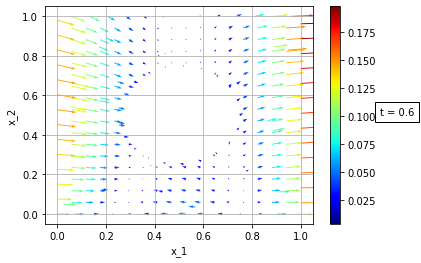

In [9]:
from neural_diff_eq.utils.plot import _plot
fig = _plot(model=solver.model, plot_variables=x, points=300, angle=[30, 220], 
            dic_for_other_variables={'t' : 0.6})

MovieWriter ffmpeg unavailable; using Pillow instead.


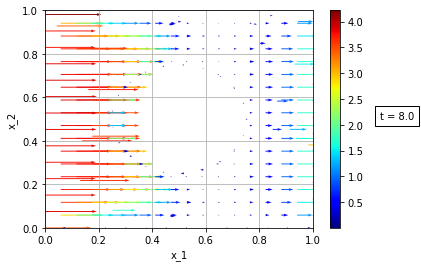

In [11]:
%load_ext autoreload
%autoreload 2
from neural_diff_eq.utils.animation import animation
fig, ani = animation(model=solver.model, plot_variables=x, domain_points=300, 
                animation_variable=t, frame_number=100)
ani.save('flow.gif')